# NP4VTT beyond the value of travel time: Bimodal (mixture of two normal) distribution

In this notebook, we briefly show how NP4VTT can be used beyond calculating the value of travel time (VTT) distribution. We use pseudo-synthetic data based on the 1989's Exxon-Valdez Contingent Valuation (CV) survey (Carson et al., 2003) as if this instrument was conducted as a two-attribute-two-alternative choice experiment.

This example was generated to answer the difficulties to find two-attribute-two-alternative choice experiments outside the transportation domain to compute the VTT. The data used in this notebook are only for illustrative purposes and it does not represent a real-life experiment. Thus, this data cannot be used to draw policy advices.

## The choice experiment
We created a choice experiment based on the Exxon-Valdez CV survey context. In this choice experiment, respondents are asked to envision a reparation plan to mitigate the negative effects of the oil spill. This mitigation plan, if implemented, will reduce the environmental damage (as a percentage of covered area with crude oil), but it may require an additional one-off tax since the government is incapable to cover all the costs.

Therefore, the experiment consists of 10 choice situations with two alternative reparation plans. Each plan consists of two attributes: 1) tax (in dollars), and 2) environmental damage after the plan is conducted (in percentage of the covered area).

An example choice situation is presented below:

| Attributes | Plan A | Plan B |
| ---------- | ------ | ------ |
| Taxes      | 20     | 50     |
| Damage     | 80     | 20     |
| **CHOICE** | X      |        |

The initial experimental design consists of a full-factorial design of 10 levels for the tax attribute, and 9 levels for the damage attribute. The ranges of the tax attribute are based on the minimum and maximum bid values presented in the Exxon-Valdez CV survey. The ranges of the damage attribute are assumed by the analyst.

From this experimental design, dominant and dominated choice situations were removed. The first alternative (Plan A) always presents a cheaper and less effective (in terms of damage) plan, whereas the second alternative (Plan B) always presents a more expensive and more effective plan.

The potential attribute levels are presented below
| Attributes | Levels |
| ---------- | ------ |
| Taxes      | 10, 30, 40, 50, 60, 70, 80, 90, 100, 120    |
| Damage     | 10, 20, 30, 40, 50, 60, 70, 80, 90          |



## Step 1: Load modules and data, and create arrays

In [17]:
import sys
sys.path.append('../../src')

In [18]:
import pandas as pd
import numpy as np
from py_np4vtt.data_format import Vars
from py_np4vtt.data_import import make_modelarrays, compute_descriptives

from py_np4vtt.model_lconstant import ModelLConstant, ConfigLConstant
from py_np4vtt.model_loclogit import ModelLocLogit, ConfigLocLogit
from py_np4vtt.model_rouwendal import ModelRouwendal, ConfigRouwendal
from py_np4vtt.model_ann import ModelANN, ConfigANN


In [19]:
df = pd.read_csv('../../data/env_synth_binormal.csv')
df.head()

,bid1,dam1,bid2,dam2,bvtt,choice,id,vtt
0,50.0,50.0,70.0,10.0,0.500000,2,1.0,5.982983
1,10.0,70.0,120.0,40.0,3.666667,2,1.0,5.982983
2,10.0,60.0,120.0,20.0,2.750000,2,1.0,5.982983
3,60.0,80.0,80.0,40.0,0.500000,2,1.0,5.982983
4,30.0,60.0,100.0,50.0,7.000000,1,1.0,5.982983


We will use:

* `id`: ID of each respondent.
* `choice`: Chosen alternative.
* `bid1`: Cost of alternative 1
* `bid2`: Cost of alternative 2
* `dam1`: Damage of alternative 1
* `dam2`: Damage of alternative 2

In [20]:
columnarrays = {
    Vars.Id: 'id',
    Vars.ChosenAlt: 'choice',
    Vars.Cost1: 'bid1',
    Vars.Cost2: 'bid2',
    Vars.Time1: 'dam1',
    Vars.Time2: 'dam2',
}

And we create the required arrays:

In [21]:
model_arrays = make_modelarrays(df, columnarrays)

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [22]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

Balanced panel: True
No. individuals: 5000
Sets per indiv.: 10

Number of non-traders:
Fast-exp. alt.: 1550
Slow-cheap alt.: 49

BVTT statistics:
No. of unique BVTT points: 57
Mean chosen BVTT: 1.3281
Minimum of BVTT: 0.125
Maximum of BVTT: 11.0


And we plot a histogram of the BVTT:

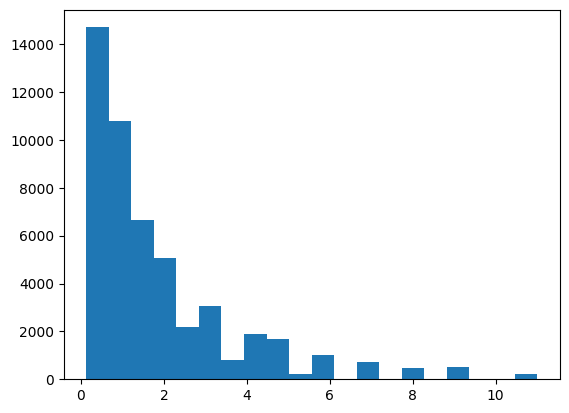

In [23]:
import matplotlib.pyplot as plt
plt.hist(model_arrays.BVTT.flatten(),bins=20)
plt.show()

## Step 3: Configure models
We configure the local constant, local Logit, Rouwendal's and ANN models. We use the same syntax as in the Norwegian VTT data:

In [24]:
# Config models
cfg_lconstant = ConfigLConstant(minimum=0, maximum=10, supportPoints=11, kernelWidth = 0.1)
cfg_loclogit = ConfigLocLogit(minimum=0, maximum=10, supportPoints=11)
cfg_rouwendal = ConfigRouwendal(minimum= 0, maximum=10, supportPoints= 21, startQ= 0.9)
cfg_ann = ConfigANN(hiddenLayerNodes=[10,10], trainingRepeats= 5, shufflesPerRepeat= 50, seed = None)

## Step 4: Estimate models

Now we estimate each of the models and we print results:

In [25]:
# Create local constant object and estimate
lc = ModelLConstant(cfg_lconstant, model_arrays)
p_lc, vtt_lc, est_time_lc = lc.run()

# Print outputs
results = pd.DataFrame(np.c_[lc.vtt_mid,p_lc],columns=['VTT','Cum. Prob.'],index=np.arange(len(lc.vtt_mid)))
print('Estimation results of Local Constant model:\n')
print('Estimation time: ' + str(round(est_time_lc,4)) + ' seconds.' + '\n')
print('VTT distribution at each mid point of the VTT grid:')
print(results)

Created a VTT grid of 11 points between 0 and 10.
Distance between points of the VTT grid is 1.0
Estimation results of Local Constant model:

Estimation time: 0.0456 seconds.

VTT distribution at each mid point of the VTT grid:
     VTT  Cum. Prob.
0    0.0    0.000000
1    0.5    0.062226
2    1.5    0.172719
3    2.5    0.300027
4    3.5    0.470208
5    4.5    0.592856
6    5.5    0.706159
7    6.5    0.736683
8    7.5    0.890278
9    8.5    0.960084
10   9.5    0.988235
11  10.0    0.988235


In [26]:
# Create local logit object and estimate
loclogit = ModelLocLogit(cfg_loclogit, model_arrays)
p_loclogit, vtt_loclogit, ll_loclogit, est_time_loclogit = loclogit.run()

# Print outputs
grid_range = ['(' + str(loclogit.vtt_grid[i]) + ' - ' + str(loclogit.vtt_grid[i+1]) + ')' for i in range(loclogit.vtt_grid.shape[0]-1)]
results = pd.DataFrame(np.c_[grid_range,np.round(p_loclogit[1:-1],4)],columns=['VTT','Prob.'],index=np.arange(len(loclogit.vtt_grid[1:])))
print('Estimation results of Local Logit model:\n')
print('Estimation time: ' + str(round(est_time_loclogit,4)) + ' seconds.')
print('Final log-likelihood: ' + str(round(ll_loclogit,2)))
print('\nEstimated Cumulative probability:')
print(results)

Created a VTT grid of 11 points between 0 and 10.
Distance between points of the VTT grid is 1.0
Estimation results of Local Logit model:

Estimation time: 0.8503 seconds.
Final log-likelihood: -20543.9

Estimated Cumulative probability:
            VTT   Prob.
0   (0.0 - 1.0)  0.0369
1   (1.0 - 2.0)  0.1123
2   (2.0 - 3.0)  0.2395
3   (3.0 - 4.0)  0.3836
4   (4.0 - 5.0)  0.5098
5   (5.0 - 6.0)  0.6112
6   (6.0 - 7.0)  0.7367
7   (7.0 - 8.0)  0.8903
8   (8.0 - 9.0)  0.9601
9  (9.0 - 10.0)     1.0


In [27]:
# Create Rouwendal model object and estimate
rouwendal = ModelRouwendal(cfg_rouwendal,model_arrays)
q_est_rw, q_se_rw, q_prob_rw, x_rw, se_rw, p_rw, vtt_rw, init_ll_rw, ll_rw, exitflag_rw, est_time_rw = rouwendal.run()

# Print outputs
results = pd.DataFrame(np.c_[rouwendal.vtt_mid,p_rw],columns=['VTT','Cum. Prob.'],index=np.arange(len(rouwendal.vtt_mid)))
print('Estimation results:\n')
print('Estimation time: ' + str(round(est_time_rw,4)) + ' seconds.')
print('Final log-likelihood: ' + str(round(ll_rw,2)))
print('Estimated prob. of consistent choice: ' + str(round(q_prob_rw,4)))
print('\nEstimated Cumulative probability:')
print(results)

Created a VTT grid of 21 points between 0 and 10.
Distance between points of the VTT grid is 0.5
Initial F-value: 16489.38
Iter No. 1: F-value: 15816.7 / Step size: 0.000488 / G-norm: 4809129.324122
Iter No. 2: F-value: 15647.03 / Step size: 0.007812 / G-norm: 62788.481486
Iter No. 3: F-value: 15614.2 / Step size: 0.015625 / G-norm: 9290.566109
Iter No. 4: F-value: 15591.76 / Step size: 0.015625 / G-norm: 4271.790004
Iter No. 5: F-value: 15572.6 / Step size: 0.015625 / G-norm: 2542.576624
Iter No. 6: F-value: 15567.97 / Step size: 0.015625 / G-norm: 781.365805
Iter No. 7: F-value: 15559.64 / Step size: 0.03125 / G-norm: 618.796301
Iter No. 8: F-value: 15546.67 / Step size: 0.0625 / G-norm: 839.254054
Iter No. 9: F-value: 15522.72 / Step size: 0.125 / G-norm: 693.931833
Iter No. 10: F-value: 15508.08 / Step size: 0.03125 / G-norm: 1586.865862
Iter No. 11: F-value: 15505.23 / Step size: 0.125 / G-norm: 842.242616
Iter No. 12: F-value: 15491.77 / Step size: 0.03125 / G-norm: 1231.463659
I

In [28]:
# Create ANN object and train
ann = ModelANN(cfg_ann,model_arrays)
ll_list_ann, r2_list_ann, vtt_list_ann, est_time_ann, avg_time_ann = ann.run()

# Print outputs
results = pd.DataFrame(np.c_[ll_list_ann,r2_list_ann],columns=['Log-likelihood','Rho-squared'],index=['Rep. ' + str(i+1) for i in range(len(ll_list_ann))])
print('Training results:')
print('Estimation time: ' + str(round(est_time_ann,4)) + ' seconds.')
print('Average estimation time: ' + str(round(avg_time_ann,4)) + ' seconds.' + '\n')
print(results)

Rep 1: CE (train): 0.2213 / CE (test): 0.2213 / LL: -55317.48 / Rho-sq: 0.68
(No VTT recovered for 45 respondents)
Rep 2: CE (train): 0.2207 / CE (test): 0.2208 / LL: -55180.33 / Rho-sq: 0.68
(No VTT recovered for 80 respondents)
Rep 3: CE (train): 0.221 / CE (test): 0.2209 / LL: -55252.43 / Rho-sq: 0.68
(No VTT recovered for 42 respondents)
Rep 4: CE (train): 0.2186 / CE (test): 0.2198 / LL: -54702.12 / Rho-sq: 0.68
(No VTT recovered for 22 respondents)
Rep 5: CE (train): 0.2212 / CE (test): 0.2211 / LL: -55298.96 / Rho-sq: 0.68
(No VTT recovered for 42 respondents)
Training results:
Estimation time: 251.0804 seconds.
Average estimation time: 50.2161 seconds.

        Log-likelihood  Rho-squared
Rep. 1   -55317.479461     0.680775
Rep. 2   -55180.334406     0.681566
Rep. 3   -55252.428479     0.681150
Rep. 4   -54702.122322     0.684326
Rep. 5   -55298.960929     0.680882


## Step 5: Visualising the 'VTT' distribution for each model:


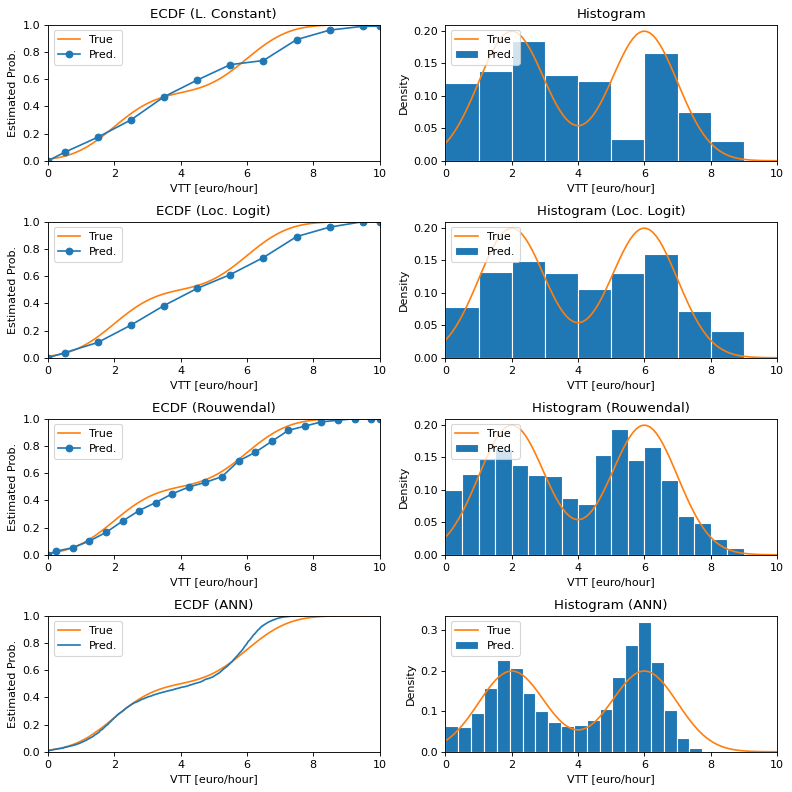

In [54]:
# Print outputs
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,2,figsize=(10,10), dpi=80)


x =  np.linspace(0,10,100)
dist1 = norm(loc=2,scale=1)
dist2 = norm(loc=6,scale=1)
pdf1 = dist1.pdf(x)
pdf2 = dist2.pdf(x)
cdf1 = dist1.cdf(x)
cdf2 = dist2.cdf(x)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot CDF
ax1[0].plot(x,(cdf1+cdf2)/2,color=colors[1])
ax1[0].plot(lc.vtt_mid,p_lc,marker='o')
ax1[0].set_xlim(0,10)
ax1[0].set_ylim(0,1)
ax1[0].set_xlabel('VTT [euro/hour]')
ax1[0].set_ylabel('Estimated Prob.')
ax1[0].set_title('ECDF (L. Constant)')
ax1[0].legend(['True','Pred.'],loc='upper left')

# 1Plot histogram
ax1[1].set_xlim(0,10)
ax1[1].set_xlabel('VTT [euro/hour]')
ax1[1].set_ylabel('Density')
ax1[1].hist(vtt_lc, bins = lc.vtt_grid,edgecolor="white",density=True)
ax1[1].plot(x,(pdf1+pdf2)/2)
ax1[1].set_title('Histogram')
ax1[1].legend(['True','Pred.'],loc='upper left')


# Plot CDF
ax2[0].plot(x,(cdf1+cdf2)/2,color=colors[1])
ax2[0].plot(loclogit.vtt_mid,p_loclogit,marker='o')
ax2[0].set_xlim(0,10)
ax2[0].set_ylim(0,1)
ax2[0].set_xlabel('VTT [euro/hour]')
ax2[0].set_ylabel('Estimated Prob.')
ax2[0].set_title('ECDF (Loc. Logit)')
ax2[0].legend(['True','Pred.'],loc='upper left')

# 2Plot histogram
ax2[1].set_xlim(0,10)
ax2[1].set_xlabel('VTT [euro/hour]')
ax2[1].set_ylabel('Density')
ax2[1].hist(vtt_loclogit, bins = loclogit.vtt_grid,edgecolor="white",density=True)
ax2[1].plot(x,(pdf1+pdf2)/2)
ax2[1].set_title('Histogram (Loc. Logit)')
ax2[1].legend(['True','Pred.'],loc='upper left')

# Plot CDF
ax3[0].plot(x,(cdf1+cdf2)/2,color=colors[1])
ax3[0].plot(rouwendal.vtt_mid,p_rw,marker='o')
ax3[0].set_xlim(0,10)
ax3[0].set_ylim(0,1)
ax3[0].set_xlabel('VTT [euro/hour]')
ax3[0].set_ylabel('Estimated Prob.')
ax3[0].set_title('ECDF (Rouwendal)')
ax3[0].legend(['True','Pred.'],loc='upper left')

# 3Plot histogram
ax3[1].set_xlim(0,10)
ax3[1].set_xlabel('VTT [euro/hour]')
ax3[1].set_ylabel('Density')
ax3[1].hist(vtt_rw, bins = rouwendal.vtt_grid,edgecolor="white",density=True)
ax3[1].plot(x,(pdf1+pdf2)/2)
ax3[1].set_title('Histogram (Rouwendal)')
ax3[1].legend(['True','Pred.'],loc='upper left')

vtt_mean_ann = vtt_list_ann.mean(axis=0)
ecdf_ann = ECDF(vtt_mean_ann)

# Plot CDF
ax4[0].plot(x,(cdf1+cdf2)/2,color=colors[1])
ax4[0].plot(ecdf_ann.x,ecdf_ann.y)
ax4[0].set_xlim(0,10)
ax4[0].set_ylim(0,1)
ax4[0].set_xlabel('VTT [euro/hour]')
ax4[0].set_ylabel('Estimated Prob.')
ax4[0].set_title('ECDF (ANN)')
ax4[0].legend(['True','Pred.'],loc='upper left')

# 4Plot histogram
ax4[1].set_xlim(0,10)
ax4[1].set_xlabel('VTT [euro/hour]')
ax4[1].set_ylabel('Density')
ax4[1].hist(vtt_mean_ann,bins=20,edgecolor="white",density=True)
ax4[1].plot(x,(pdf1+pdf2)/2)
ax4[1].set_title('Histogram (ANN)')
ax4[1].legend(['True','Pred.'],loc='upper left')

plt.tight_layout()
plt.show()